# Introduction
The Sloan Digital Sky Survey or SDSS is a multi-spectral imaging map using at Apache Point Observatory in New Mexico. It is the most detailed three-dimensional map of the universe ever made, with multi-color images of one third of the sky, and spectra for more than three million astronomical objects.

Data used in this project are results from a query which joins two tables: PhotoObj, which contains photometric data, and SpecObj, which contains spectral data. Data is retrieved from SkyServer SQL Search.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
df=pd.read_csv("Skyserver_2.csv")

In [3]:
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237670e+18,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771.0,8.168630e+18,STAR,0.000115,7255,56597.0,832
1,1.237670e+18,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220.0,9.333950e+18,STAR,-0.000093,8290,57364.0,868
2,1.237670e+18,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13.0,3.221210e+18,STAR,0.000165,2861,54583.0,42
3,1.237670e+18,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121.0,2.254060e+18,GALAXY,0.058155,2002,53471.0,35
4,1.237670e+18,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191.0,2.390310e+18,GALAXY,0.072210,2123,53793.0,74


# EDA & PREPROCESSING

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   objid      100000 non-null  float64
 1   ra         99990 non-null   float64
 2   dec        99967 non-null   float64
 3   u          100000 non-null  float64
 4   g          99980 non-null   float64
 5   r          100000 non-null  float64
 6   i          100000 non-null  float64
 7   z          99966 non-null   float64
 8   run        100000 non-null  int64  
 9   rerun      100000 non-null  int64  
 10  camcol     100000 non-null  int64  
 11  field      99987 non-null   float64
 12  specobjid  100000 non-null  float64
 13  class      100000 non-null  object 
 14  redshift   99984 non-null   float64
 15  plate      100000 non-null  int64  
 16  mjd        99990 non-null   float64
 17  fiberid    100000 non-null  int64  
dtypes: float64(12), int64(5), object(1)
memory usage: 13.7+ MB


# Checking for Null values

In [5]:
df.isnull().sum()

objid         0
ra           10
dec          33
u             0
g            20
r             0
i             0
z            34
run           0
rerun         0
camcol        0
field        13
specobjid     0
class         0
redshift     16
plate         0
mjd          10
fiberid       0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isnull().sum()

objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

In [8]:
df.nunique()

objid            4
ra           99861
dec          99862
u            79758
g            85799
r            87857
i            88515
z            89348
run            516
rerun            1
camcol           6
field          840
specobjid    52512
class            3
redshift     91143
plate         6117
mjd           2167
fiberid       1000
dtype: int64

In [9]:
df.corr().style.background_gradient(cmap='coolwarm')

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
objid,1.000000,-0.043399,-0.048919,0.010383,0.017204,0.017462,0.020686,0.022218,0.931708,nan,-0.022802,-0.098064,0.358638,0.022460,0.358639,0.405519,0.076128
ra,-0.043399,1.000000,0.076927,0.020947,0.017498,0.012515,0.006289,0.001357,-0.064190,nan,-0.007659,0.021925,-0.056718,-0.006493,-0.056718,-0.030308,-0.027564
dec,-0.048919,0.076927,1.000000,-0.027443,-0.013434,-0.004809,-0.001228,0.004630,-0.055968,nan,0.081492,-0.113233,0.017409,0.011147,0.017408,0.025835,0.029331
u,0.010383,0.020947,-0.027443,1.000000,0.843241,0.692892,0.615984,0.562030,0.010513,nan,0.006589,0.012052,0.008799,0.172636,0.008798,-0.011161,0.017278
g,0.017204,0.017498,-0.013434,0.843241,1.000000,0.956711,0.915000,0.886673,0.018585,nan,0.011774,0.007746,0.147662,0.422288,0.147661,0.114530,0.068862
r,0.017462,0.012515,-0.004809,0.692892,0.956711,1.000000,0.976034,0.961442,0.020389,nan,0.013335,0.002361,0.203267,0.453345,0.203267,0.171314,0.085820
i,0.020686,0.006289,-0.001228,0.615984,0.915000,0.976034,1.000000,0.977168,0.024537,nan,0.015187,-0.001151,0.236331,0.449645,0.236330,0.207153,0.093046
z,0.022218,0.001357,0.004630,0.562030,0.886673,0.961442,0.977168,1.000000,0.027006,nan,0.013580,-0.003644,0.251837,0.440936,0.251836,0.226421,0.096737
run,0.931708,-0.064190,-0.055968,0.010513,0.018585,0.020389,0.024537,0.027006,1.000000,nan,0.001296,-0.164679,0.366025,0.025526,0.366025,0.414029,0.095217
rerun,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


# Dropping features we will not need

In [10]:
#Coloumn having low corelation are dropped
df = df.drop(columns=['run', 'rerun', 'camcol', 'field', 'objid', 'specobjid', 'fiberid'])
df

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd
0,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,STAR,0.000115,7255,56597.0
1,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,STAR,-0.000093,8290,57364.0
2,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,STAR,0.000165,2861,54583.0
3,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,GALAXY,0.058155,2002,53471.0
4,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,GALAXY,0.072210,2123,53793.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,228.674917,19.179460,19.32631,18.82748,18.65659,18.60481,18.60917,QSO,0.438182,3951,55681.0
99996,173.757382,36.441603,18.33687,17.30365,17.16037,17.14895,17.14419,STAR,-0.000497,2012,53493.0
99997,205.426531,38.499053,17.50690,15.63152,15.22328,15.04469,15.28668,GALAXY,0.004587,2005,53472.0
99998,337.135144,-9.635967,19.33946,17.21436,16.29697,15.86745,15.51556,GALAXY,0.084538,721,52228.0


In [11]:
#descriptive statistics of data
df.describe()

,ra,dec,u,g,r,i,z,redshift,plate,mjd
count,99864.000000,99864.000000,99864.000000,99864.000000,99864.000000,99864.000000,99864.000000,9.986400e+04,99864.000000,99864.000000
mean,177.511187,25.056243,18.637907,17.407180,16.881779,16.625665,16.467229,1.706493e-01,2588.158435,53914.084595
std,78.048692,20.569086,0.832290,0.985924,1.133399,1.209610,1.281869,4.376515e-01,2210.415234,1547.069751
min,0.013061,-19.495456,10.611810,9.668339,9.005167,8.848403,8.947795,-4.136078e-03,266.000000,51608.000000
25%,136.350489,6.774206,18.212727,16.853110,16.196850,15.865275,15.620007,9.232500e-07,1186.000000,52733.750000
50%,180.408706,23.925449,18.873260,17.515860,16.890665,16.599945,16.428475,4.599466e-02,2092.500000,53726.000000
75%,224.369890,40.351354,19.273328,18.056060,17.585750,17.344953,17.234882,9.542210e-02,2910.000000,54585.000000
max,359.999615,84.490494,19.599950,19.996050,31.990100,32.141470,29.383740,7.011245e+00,11703.000000,58543.000000


# Visualizing The Data

# Boxplot

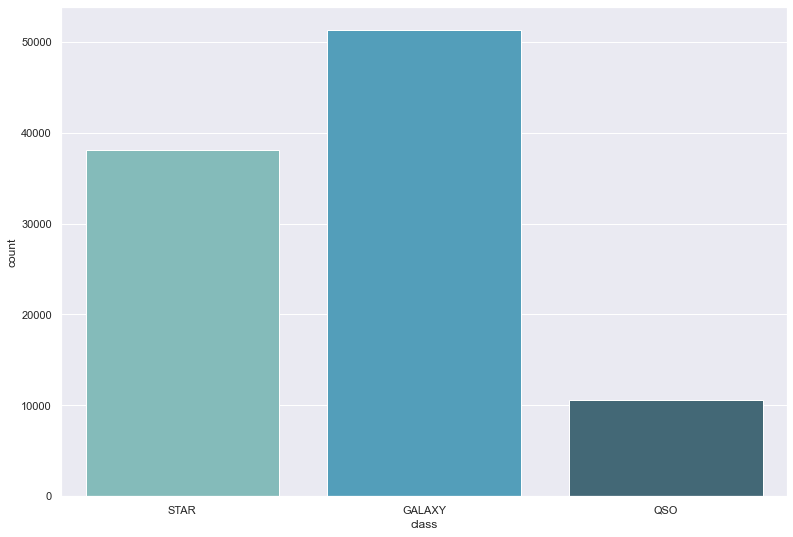

In [12]:
color_palette = 'GnBu_d'
sns.set()
fig = plt.gcf()
fig.set_size_inches(13,9)
sns.countplot(df['class'], palette=color_palette)
plt.show()

<AxesSubplot:xlabel='class', ylabel='mjd'>

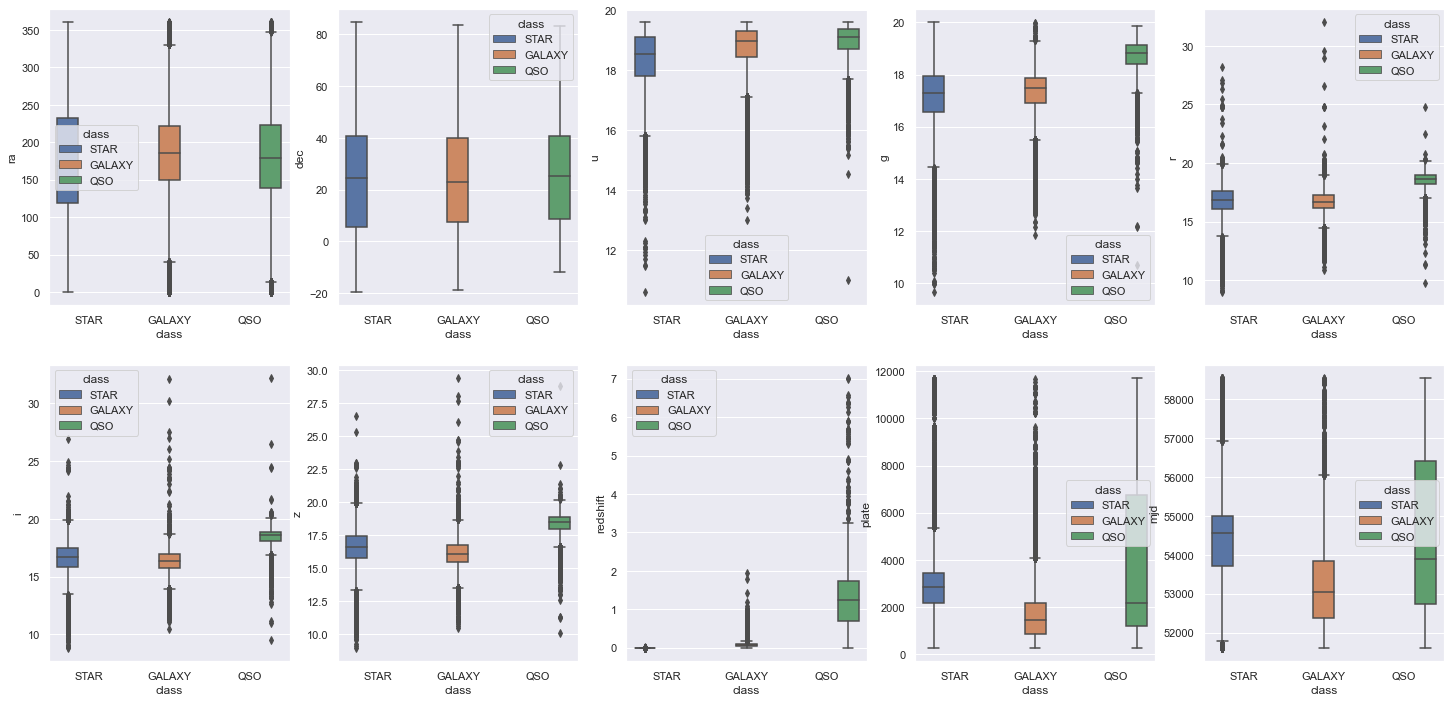

In [13]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows = 2, ncols = 5,
                                                                      figsize = (25,12))


sns.boxplot(ax = ax1, x = 'class', y = 'ra', hue = 'class', data = df)
sns.boxplot(ax = ax2, x = 'class', y = 'dec', hue = 'class', data = df)
sns.boxplot(ax = ax3, x = 'class', y = 'u', hue = 'class', data = df)
sns.boxplot(ax = ax4, x = 'class', y = 'g', hue = 'class', data = df)
sns.boxplot(ax = ax5, x = 'class', y = 'r', hue = 'class', data = df)
sns.boxplot(ax = ax6, x = 'class', y = 'i', hue = 'class', data = df)
sns.boxplot(ax = ax7, x = 'class', y = 'z', hue = 'class', data = df)
sns.boxplot(ax = ax8, x = 'class', y = 'redshift', hue = 'class', data = df)
sns.boxplot(ax = ax9, x = 'class', y = 'plate', hue = 'class', data = df)
sns.boxplot(ax = ax10, x = 'class', y = 'mjd', hue = 'class', data = df)

In [14]:
stars = df[df['class'] == 'STAR']
quasars = df[df['class'] == 'QSO']
galaxies = df[df['class'] == 'GALAXY']

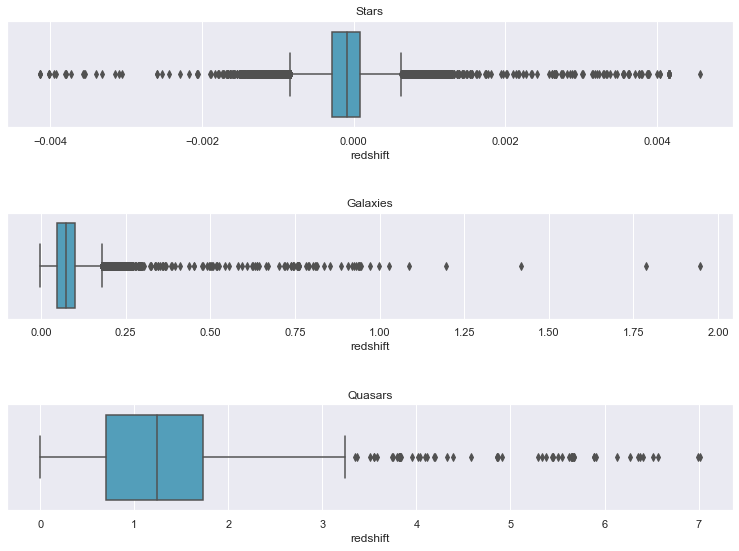

In [15]:
sns.set(style='darkgrid')
fig, axs = plt.subplots(nrows=3)
fig = plt.gcf()
fig.set_size_inches(13,9)
plt.subplots_adjust(hspace=0.8)
sns.boxplot(stars['redshift'], palette=color_palette, ax=axs[0]).set_title('Stars')
sns.boxplot(galaxies['redshift'], palette=color_palette, ax=axs[1]).set_title('Galaxies')
sns.boxplot(quasars['redshift'], palette=color_palette, ax=axs[2]).set_title('Quasars')
plt.show()

# Pairplot

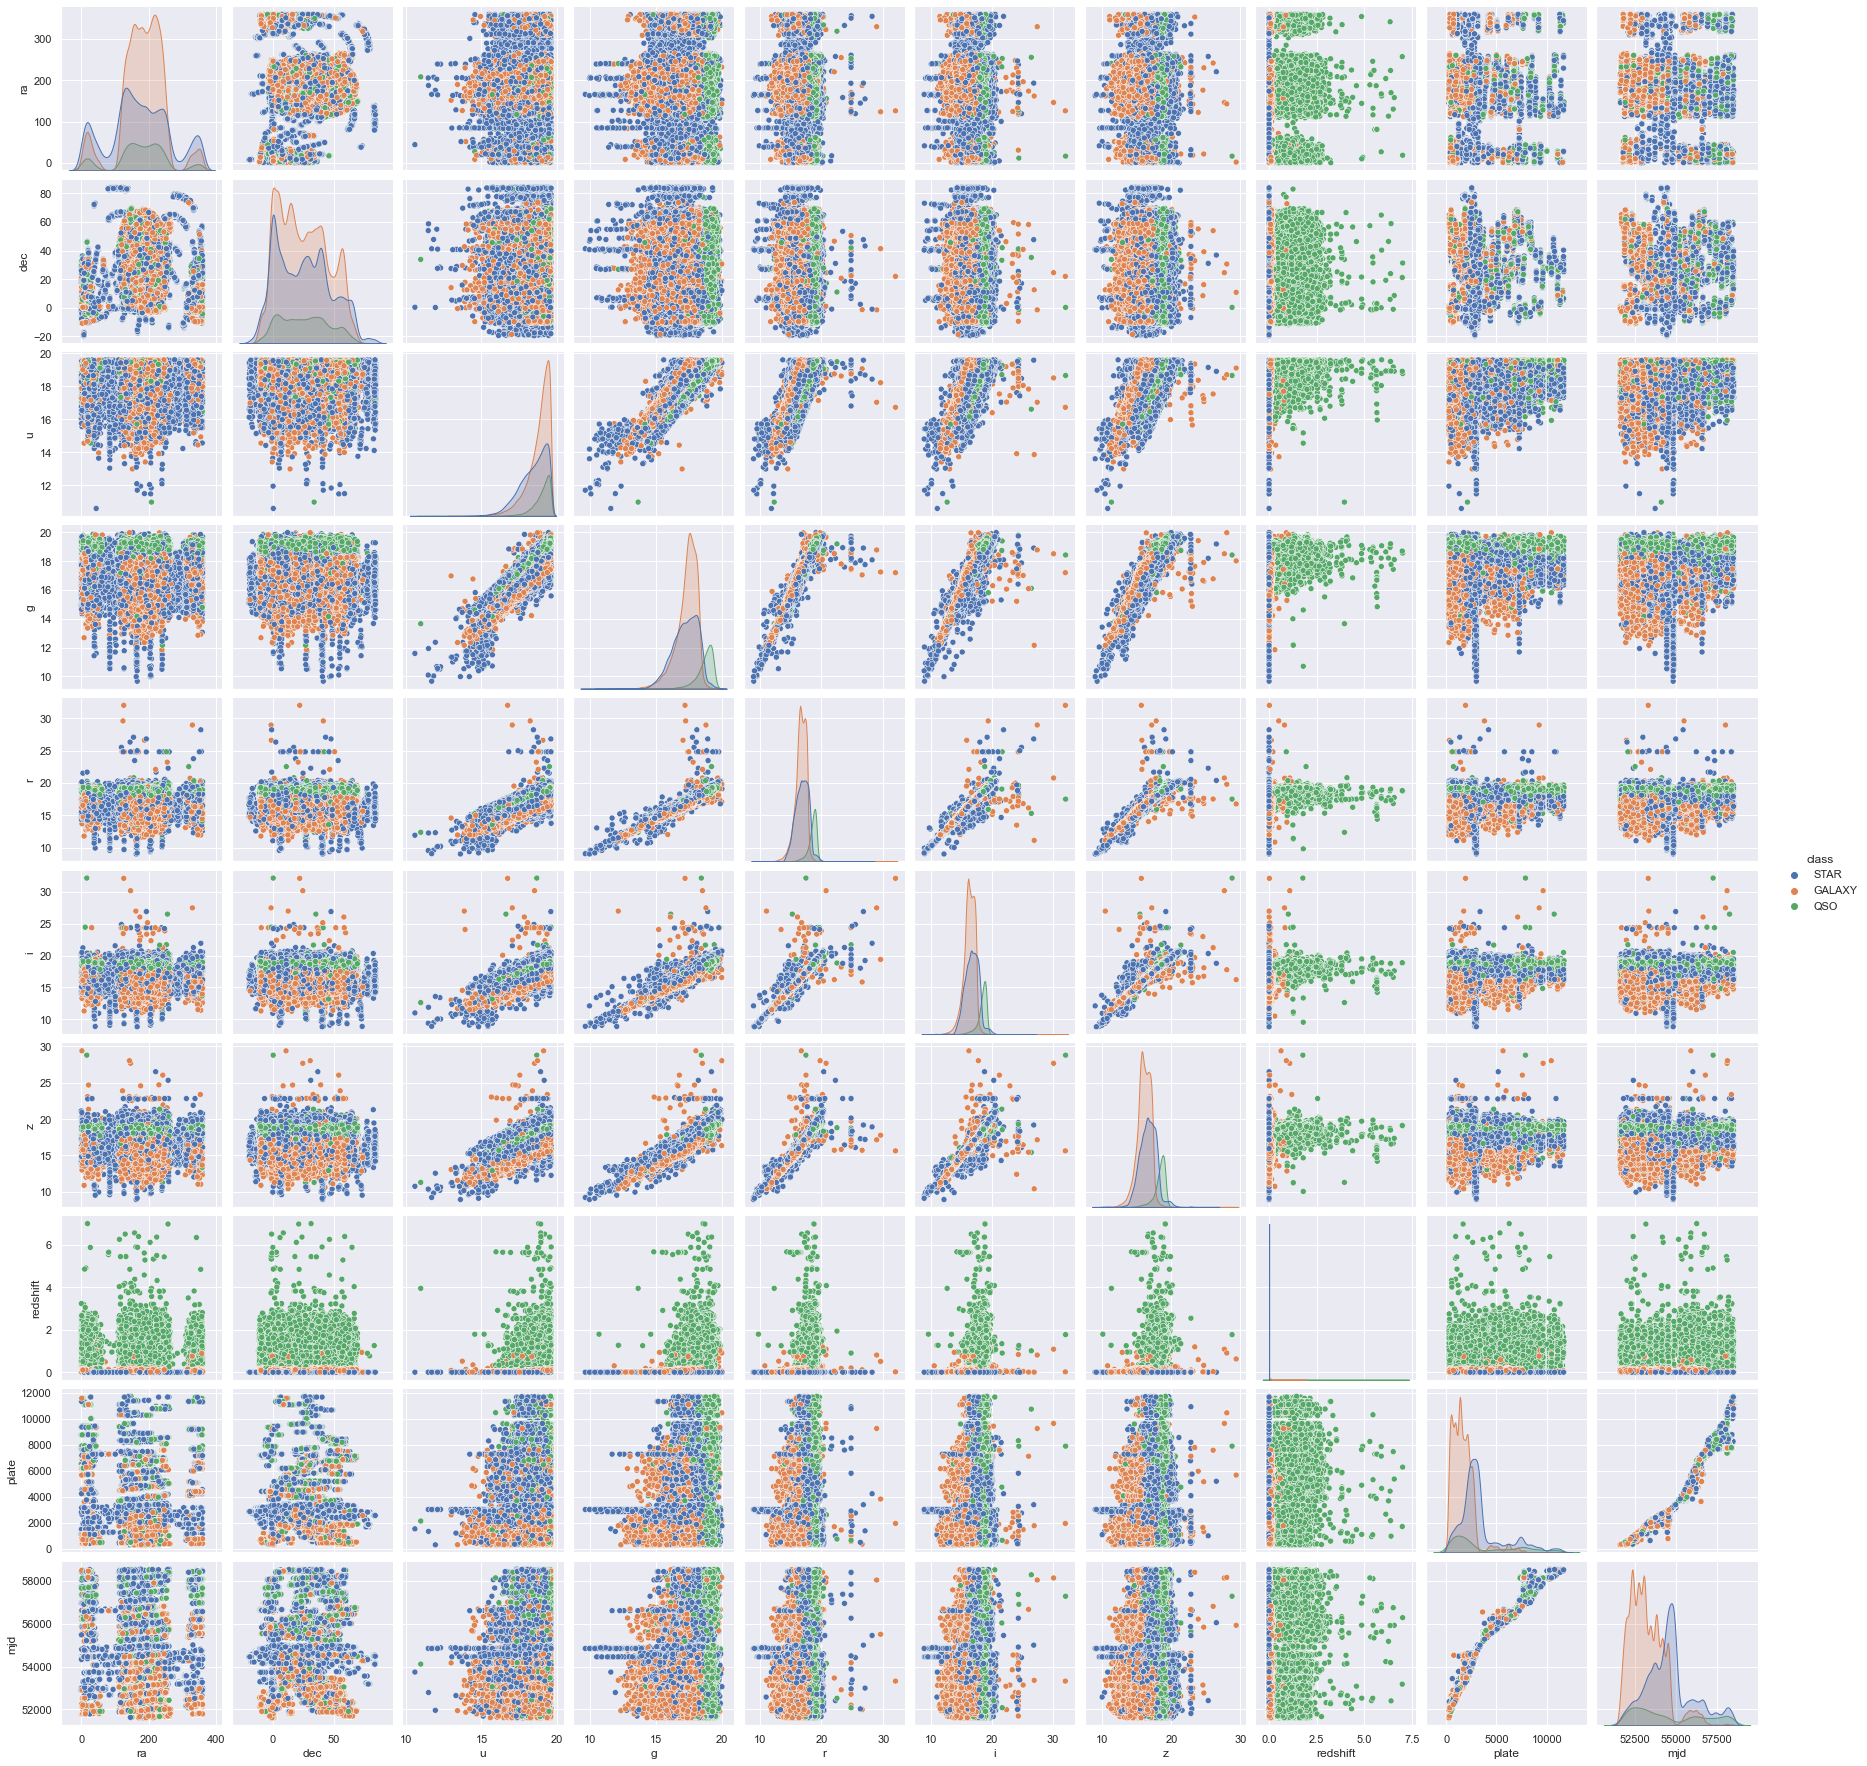

In [16]:
sns.set(style='darkgrid')
sns.pairplot(df, hue='class')
plt.show()

# Heatmap

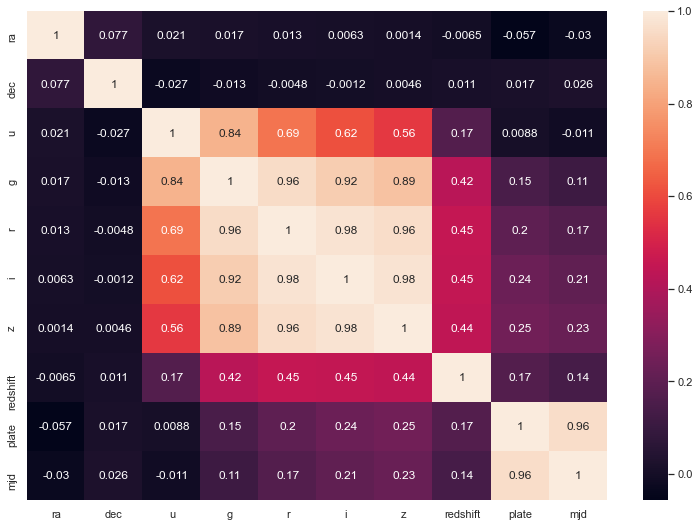

In [17]:
df_corr = df.corr()
fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(df_corr, annot=True)
plt.show()

# SEPRATION OF TARGET & INDEPENDENT VARIABLES

In [18]:
x = df[['u','g','r','i','z','redshift']]
y = df['class']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.30, random_state=1)

In [19]:
x

,u,g,r,i,z,redshift
0,18.69254,17.13867,16.55555,16.34662,16.17639,0.000115
1,18.47633,17.30546,17.24116,17.32780,17.37114,-0.000093
2,16.47714,15.31072,15.55971,15.72207,15.82471,0.000165
3,18.63561,16.88346,16.09825,15.70987,15.43491,0.058155
4,18.88325,17.87948,17.47037,17.17441,17.05235,0.072210
...,...,...,...,...,...,...
99995,19.32631,18.82748,18.65659,18.60481,18.60917,0.438182
99996,18.33687,17.30365,17.16037,17.14895,17.14419,-0.000497
99997,17.50690,15.63152,15.22328,15.04469,15.28668,0.004587
99998,19.33946,17.21436,16.29697,15.86745,15.51556,0.084538


In [20]:
y

0          STAR
1          STAR
2          STAR
3        GALAXY
4        GALAXY
          ...  
99995       QSO
99996      STAR
99997    GALAXY
99998    GALAXY
99999      STAR
Name: class, Length: 99864, dtype: object

Train Score: 0.9582856488899062
Classification Test Score: 0.9579439252336449 

Classification Performance:
               precision    recall  f1-score   support

      GALAXY       0.97      0.95      0.96     15310
         QSO       0.96      0.96      0.96      3145
        STAR       0.94      0.97      0.95     11505

    accuracy                           0.96     29960
   macro avg       0.96      0.96      0.96     29960
weighted avg       0.96      0.96      0.96     29960
 



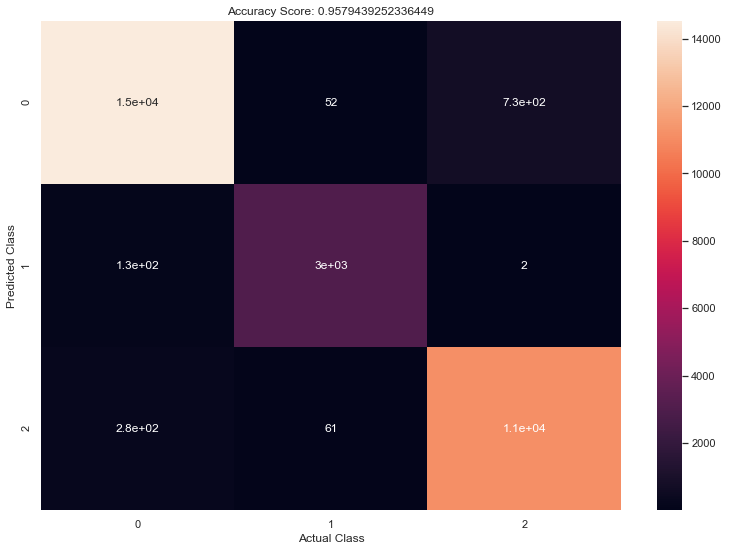

In [25]:
logreg = LogisticRegression()

logreg.fit(xtrain, ytrain)
ypred = logreg.predict(xtest)

accuracy = logreg.score(xtest, ytest)

print('Train Score:', logreg.score(xtrain,ytrain))
print('Classification Test Score:', accuracy ,'\n')
print('Classification Performance:\n', classification_report(ytest, ypred),'\n')


cm = confusion_matrix(ytest, ypred)

fig = plt.gcf()
fig.set_size_inches(13,9)
sns.heatmap(cm, annot=True).set_title('Accuracy Score: {}'.format(accuracy))
plt.xlabel('Actual Class')
plt.ylabel('Predicted Class')

plt.show()

In [28]:
def mymodel(model):
    model.fit(xtrain,ytrain)
    ypred=model.predict(xtest)
    ac=accuracy_score(ytest,ypred)
    print(f"{classification_report(ytest,ypred)}")
    print('Confusion Matrix: \n', confusion_matrix(ytest, ypred))
    
knn=KNeighborsClassifier()
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()

In [29]:
mymodel(knn)

              precision    recall  f1-score   support

      GALAXY       0.97      0.95      0.96     15310
         QSO       0.98      0.96      0.97      3145
        STAR       0.94      0.97      0.96     11505

    accuracy                           0.96     29960
   macro avg       0.97      0.96      0.96     29960
weighted avg       0.96      0.96      0.96     29960

Confusion Matrix: 
 [[14609    36   665]
 [  134  3006     5]
 [  290    13 11202]]


In [30]:
mymodel(dt)

              precision    recall  f1-score   support

      GALAXY       0.99      0.99      0.99     15310
         QSO       0.95      0.95      0.95      3145
        STAR       1.00      1.00      1.00     11505

    accuracy                           0.99     29960
   macro avg       0.98      0.98      0.98     29960
weighted avg       0.99      0.99      0.99     29960

Confusion Matrix: 
 [[15136   151    23]
 [  160  2985     0]
 [   19     0 11486]]


In [31]:
mymodel(rf)

              precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99     15310
         QSO       0.99      0.95      0.97      3145
        STAR       1.00      1.00      1.00     11505

    accuracy                           0.99     29960
   macro avg       0.99      0.98      0.99     29960
weighted avg       0.99      0.99      0.99     29960

Confusion Matrix: 
 [[15248    45    17]
 [  146  2998     1]
 [   16     0 11489]]


# HYPERPARAMETER TUNNING

In [32]:
accuracy=[]
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xtrain, ytrain)
    ypred = knn.predict(xtest)
    accuracy.append(accuracy_score(ytest, ypred))

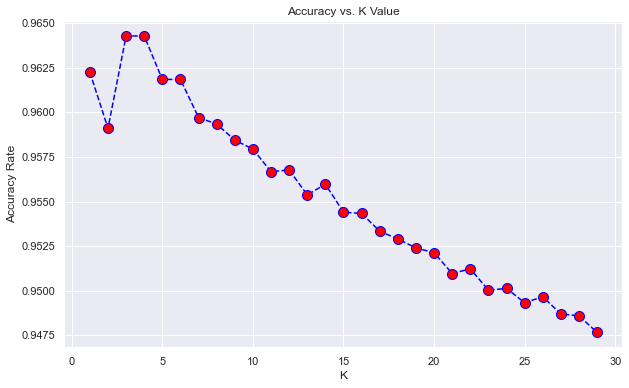

In [33]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30), accuracy, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)

plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')
plt.grid(True)
plt.show()

In [34]:
knn=KNeighborsClassifier(n_neighbors=4)
knn.fit(xtrain,ytrain)
ypred=knn.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97     15310
         QSO       0.98      0.95      0.97      3145
        STAR       0.96      0.97      0.96     11505

    accuracy                           0.96     29960
   macro avg       0.97      0.96      0.97     29960
weighted avg       0.96      0.96      0.96     29960



# Comparision of Actual & Predicted values

In [35]:
data = {'Actual': ytest,'Predicted':ypred}

df1 = pd.DataFrame(data, columns = ['Actual', 'Predicted'])
df1

,Actual,Predicted
14071,STAR,STAR
77925,GALAXY,GALAXY
30691,GALAXY,GALAXY
25952,GALAXY,GALAXY
71754,STAR,STAR
...,...,...
7896,STAR,STAR
77576,STAR,STAR
11258,STAR,STAR
37806,STAR,STAR
